# Профилирование и оптимизация вычислений Dask

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Лекция "Dask"
* https://docs.dask.org/en/stable/diagnostics-local.html#profiler
* https://docs.dask.org/en/stable/diagnostics-local.html#progress-bar
* https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.broken_barh.html
* https://docs.python.org/3/library/stdtypes.html#str.rsplit
* https://docs.dask.org/en/stable/api.html#dask.datasets.make_people
* https://docs.dask.org/en/stable/scheduling.html
* https://distributed.dask.org/en/stable/client.html

## Задачи для совместного разбора

In [1]:
import dask

dask.__version__

'2023.3.2'

In [3]:
#!pip install dask==2023.3.2
#!pip install distributed==2023.3.2

1\. Создайте массив целых чисел. Вычислите среднее значение элементов. Для демонстрации прогресса используйте ProgressBar. Модифицируйте ProgressBar.

In [1]:
import dask.array as da
from dask.diagnostics import ProgressBar

a = da.random.randint(0, 100, size=(100000, 10000))

In [2]:
with ProgressBar():
    a.mean().compute()

[########################################] | 100% Completed | 6.22 ss


In [3]:
import contextlib
class MyProgressBar(ProgressBar):
    def __init__(self, char: str = "#"):
        self.char = char
        assert len(self.char) == 1, "Char should have len=1"
        super().__init__()
        
    def _draw_bar(self, frac, elapsed):
        from dask.utils import format_time

        bar = self.char * int(self._width * frac)
        percent = int(100 * frac)
        elapsed = format_time(elapsed)
        msg = "\r[{0:<{1}}] | {2}% Completed | {3}".format(
            bar, self._width, percent, elapsed
        )
        with contextlib.suppress(ValueError):
            if self._file is not None:
                self._file.write(msg)
                self._file.flush()

In [4]:
with MyProgressBar(char="*"):
    a.mean().compute()

[****************************************] | 100% Completed | 5.93 ss


In [5]:
with MyProgressBar(char='*'):
    a.mean().compute()

[****************************************] | 100% Completed | 6.20 ss


2\. Отберите строки, сумма элементов которых является четной. Вычислите среднее значение полученного массива, используя различные планировщики. 

In [6]:
a = da.random.randint(0, 100, size=(100000, 10000))
mask = a.sum(axis=1) % 2 == 0
b = a[mask]
b

dask.array<getitem_variadic, shape=(nan, 10000), dtype=int32, chunksize=(nan, 5792), chunktype=numpy.ndarray>

In [7]:
%%time
b.mean().compute(scheduler='threads')

CPU times: total: 44.9 s
Wall time: 6.44 s


49.50047506340489

In [8]:
%%time
b.mean().compute(scheduler='processes')

OSError: [WinError 1450] Недостаточно системных ресурсов для завершения операции

In [9]:
%%time
b.mean().compute(scheduler='sync')

CPU times: total: 19.4 s
Wall time: 31.9 s


49.50047506340489

3\. Изучите, как влияет вызов persist на скорость вычислений максимума и среднего значения элементов массива из предыдущей задачи.

In [10]:
a = da.random.randint(0, 100, size=(100000, 10000))
mask = a.sum(axis=1) % 2 == 0
b = a[mask]

In [11]:
%%time
mx = b.max()
avg = b.mean()

print(
    mx.compute(),
    avg.compute()
)

99 49.5013441536893
CPU times: total: 1min 14s
Wall time: 11.7 s


In [12]:
%%time
mx = b.max()
avg = b.mean()

print(
    dask.compute(mx, avg)
)

NameError: name 'dask' is not defined

In [13]:
%%time
a = da.random.randint(0, 100, size=(100000, 10000))
mask = a.sum(axis=1) % 2 == 0
b = a[mask].persist()

CPU times: total: 35.6 s
Wall time: 5.56 s


In [14]:
b

dask.array<getitem_variadic, shape=(nan, 10000), dtype=int32, chunksize=(nan, 5792), chunktype=numpy.ndarray>

In [15]:
mx = b.max()
avg = b.mean()

In [16]:
%%time
print(
    mx.compute(),
    avg.compute()
)

99 49.500016248401536
CPU times: total: 3.45 s
Wall time: 587 ms


In [17]:
mx

dask.array<amax-aggregate, shape=(), dtype=int32, chunksize=(), chunktype=numpy.ndarray>

4\. Изучите основные возможности Client на примере предыдущей задачи.

In [18]:
# !pip install --user bokeh==2.4.2

In [19]:
from dask.distributed import Client
client = Client()
client

import dask.array as da
a = da.random.randint(0, 100, size=(100000, 10000))
mask = a.sum(axis=1) % 2 == 0
b = a[mask]

b.mean().compute()

%%time
a = da.random.randint(0, 100, size=(100000, 10000))
mask = a.sum(axis=1) % 2 == 0
b = a[mask].persist()

a = da.random.randint(0, 500, size=(30000, 10000))
mask = a.sum(axis=1) % 3 == 0
b = a[mask]

%%time
b.mean().compute()

%%time
f = client.compute(b.mean())
f

f

f.result()

Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x0000024ACCEAAE50>>
Traceback (most recent call last):
  File "C:\Users\cosit\anaconda3\lib\site-packages\distributed\utils_perf.py", line 179, in _gc_callback
    if info["generation"] != 2:
KeyboardInterrupt: 

KeyboardInterrupt



## Лабораторная работа 11

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy`, `pandas` и `dask`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy`, структур `pandas` или структур `dask` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

__Важно: задачи 1-7 решаются без запуска клиента `dask.distributed.Client`__

In [1]:
import dask.array as da

<p class="task" id="1"></p>

1\. Создайте массив из 1 млн. строк и 256 столбцов, заполненный числами из нормального распределения с $\mu=10$ и $\sigma=5$. При помощи метода `rechunk` сделайте так, чтобы данные были разбиты на сегменты по 250 тыс. строк.

Используя `dask.diagnostics.Profiler`, исследуйте процесс вычисления суммы элементов этого массива. Результат представьте в виде `pd.DataFrame` со столбцами: `key`, `start_time`, `end_time`, `worker_id`, `time_taken` и `task_type`. В поле `key` должны храниться строки - идентификаторы задач. 

В поле `task_type` должны храниться строки - типы задач, которые можно извлечь из `key`. Например, для строки "normal-33a0474c5b5133263153dbd93d8fa610" категорией является "normal", а для строки "rechunk-merge-sum-290d08054ec62d2e1cd1c42b68f" - "rechunk-merge-sum".

Выведите на экран количество задач и количество уникальных типов этих задач

In [3]:
arr1 = da.random.normal(loc=10, scale=5, size=(1_000_000, 256)).rechunk(250_000)

In [4]:
arr1

dask.array<rechunk-merge, shape=(1000000, 256), dtype=float64, chunksize=(250000, 256), chunktype=numpy.ndarray>

In [5]:
from dask.diagnostics import Profiler

with Profiler() as prof:
    arr1.sum().compute()

In [6]:
res = prof.results

In [7]:
from functools import reduce
import dask
import re
lst = []
def f(acc, taskdata):
    if type(acc) == dask.diagnostics.profile.TaskData:
        p = re.compile(r"^([\w-]+)-")
        task_type = p.findall(taskdata.key[0])[0]
        acc = [[
            acc.key[0], acc.start_time, acc.end_time,
            acc.worker_id, acc.end_time - acc.start_time, task_type
        ]]
        
    p = re.compile(r"^([\w-]+)-")
    task_type = p.findall(taskdata.key[0])[0]
    acc.append([
        taskdata.key[0], taskdata.start_time, taskdata.end_time,
        taskdata.worker_id, taskdata.end_time - taskdata.start_time, task_type
    ])
    return acc

data = reduce(
    f, res
)

In [8]:
import pandas as pd

df = pd.DataFrame(data, columns=['key', 'start_time', 'end_time', 'worker_id', 'time_taken', 'task_type'])
df

,key,start_time,end_time,worker_id,time_taken,task_type
0,normal-9813bce4e6838b5419e6b0f66cfe26e5,32.642233,33.318546,21308,0.676313,normal
1,normal-9813bce4e6838b5419e6b0f66cfe26e5,32.642245,33.331834,14208,0.689589,normal
2,normal-9813bce4e6838b5419e6b0f66cfe26e5,32.642253,33.321785,20572,0.679532,normal
3,normal-9813bce4e6838b5419e6b0f66cfe26e5,32.642261,33.326236,16948,0.683976,normal
4,normal-9813bce4e6838b5419e6b0f66cfe26e5,32.642268,33.310722,9484,0.668454,normal
5,normal-9813bce4e6838b5419e6b0f66cfe26e5,32.642276,33.311886,4016,0.669610,normal
6,normal-9813bce4e6838b5419e6b0f66cfe26e5,32.642283,33.337145,9920,0.694862,normal
7,normal-9813bce4e6838b5419e6b0f66cfe26e5,32.642290,33.365186,14192,0.722896,normal
8,normal-9813bce4e6838b5419e6b0f66cfe26e5,33.310737,33.984775,9484,0.674037,normal
9,normal-9813bce4e6838b5419e6b0f66cfe26e5,33.311895,34.005044,4016,0.693149,normal


In [9]:
unique = len(set(df['task_type']))
print(f'количество задач: {len(df)},количество уникальных задач: {unique}')

количество задач: 33,количество уникальных задач: 6


<p class="task" id="2"></p>

2\. Профайлер `dask.diagnostics.Profiler` возвращает временные метки `start_time` и `end_time`, начиная с момента запуска ядра ноутбука. Напишите собственную версию профайлера `ProfilerWithInitialTimestamp`, который возвращает результаты замеров времени, начиная с момента запуска ячейки. Результат представьте в виде `pd.DataFrame` со столбцами: `key`, `start_time`, `end_time`, `worker_id`, `time_taken` и `task_type` аналогично заданию 1. Выведите на экран минимум и максимум по столбцу `start_time`.

In [10]:
from time import time
class ProfilerWithInitialTimestamp(Profiler):
    def __init__(self):
        super().__init__()
        self.time = time()
        
    def __enter__(self):
        self.clear()
        self.start_time = time() - self.time
        return super().__enter__()

    def __exit__(self, *args):
        self.end_time = time() - self.time
        return super().__exit__(*args)
    
    def _pretask(self, key, dsk, state):
        start = time() - self.time
        self._results[key] = (key, dsk[key], start)

    def _posttask(self, key, value, dsk, state, id):
        end = time() - self.time
        self._results[key] += (end, id)

In [11]:
with ProfilerWithInitialTimestamp() as prof_:
    arr1.sum().compute()

In [12]:
res_ = prof_.results

In [13]:
data_ = reduce(
    f, res_
)

df_ = pd.DataFrame(data_, columns=['key', 'start_time', 'end_time', 'worker_id', 'time_taken', 'task_type'])
df_

,key,start_time,end_time,worker_id,time_taken,task_type
0,normal-9813bce4e6838b5419e6b0f66cfe26e5,0.000000,0.697682,14192,0.697682,normal
1,normal-9813bce4e6838b5419e6b0f66cfe26e5,0.000000,0.706189,9920,0.706189,normal
2,normal-9813bce4e6838b5419e6b0f66cfe26e5,0.000000,0.697682,21308,0.697682,normal
3,normal-9813bce4e6838b5419e6b0f66cfe26e5,0.000000,0.690173,20572,0.690173,normal
4,normal-9813bce4e6838b5419e6b0f66cfe26e5,0.000000,0.706189,14208,0.706189,normal
5,normal-9813bce4e6838b5419e6b0f66cfe26e5,0.000000,0.706189,9484,0.706189,normal
6,normal-9813bce4e6838b5419e6b0f66cfe26e5,0.000000,0.721817,4016,0.721817,normal
7,normal-9813bce4e6838b5419e6b0f66cfe26e5,0.000000,0.721817,16948,0.721817,normal
8,normal-9813bce4e6838b5419e6b0f66cfe26e5,0.690173,1.427639,20572,0.737466,normal
9,rechunk-split-476dcac6d1cb43559a380ccc5b73676c,0.697682,0.697682,14192,0.000000,rechunk-split


In [14]:
min(df_['start_time']), max(df_['start_time'])

(0.0, 2.0094029903411865)

<p class="task" id="3"></p>

3\. Визуализируйте процесс вычислений в виде горизонтальных столбчатых диаграмм с разрывами. По горизонтальной оси откладывается время, по вертикальной - номер задачи. Каждая задача располагается по вертикали на высоте, соответствующей своему номеру. Ширина столбца (по горизонтали) соответствует продолжительности выполнения задачи. Цвет столбца соответствует типу задачи. Каждый столбик должен иметь подпись, состояющую из нескольких первых символов идентификатора задачи.

Примерный вид итоговой визуализации:
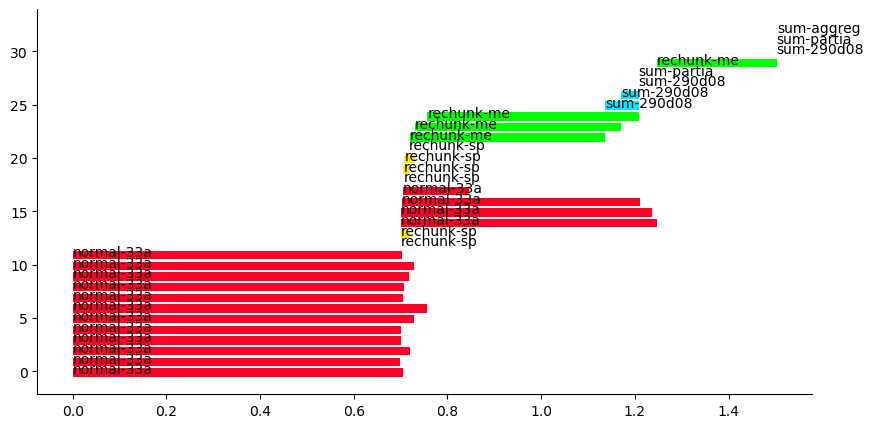

In [15]:
def f3(acc, taskdata):
    if type(acc) == dask.diagnostics.profile.TaskData:
        acc = [(acc.start_time, acc.end_time - acc.start_time, acc.key[0][:10])]
    acc.append((taskdata.start_time, taskdata.end_time - taskdata.start_time, taskdata.key[0][:10]))
    return acc
data3 = reduce(f3, res_)

In [25]:
import random
number_of_colors = len(set(map(lambda x: x[2], data3)))
tasks_set = set(map(lambda x: x[2], data3))
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
colordic = dict(zip(tasks_set, color))
colordic

{'sum-c37446': '#3FB720',
 'sum-partia': '#B404DA',
 'normal-981': '#2A436E',
 'sum-aggreg': '#942622',
 'rechunk-sp': '#F5C866',
 'rechunk-me': '#5195F6'}

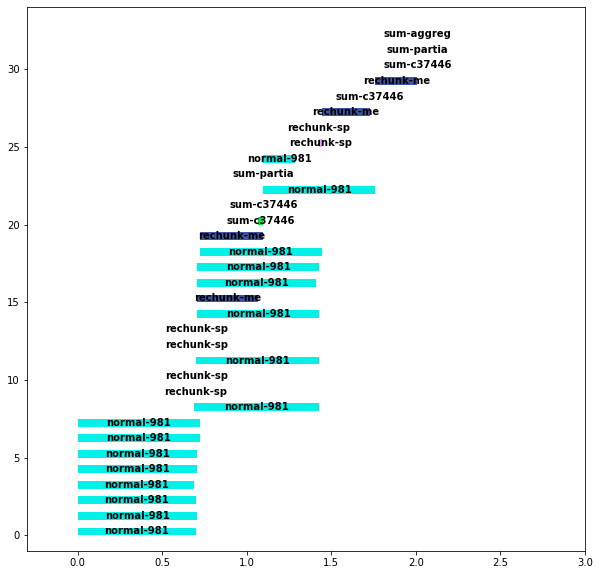

In [29]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

number_of_colors = len(set(map(lambda x: x[2], data3)))
tasks_set = set(map(lambda x: x[2], data3))
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
colordic = dict(zip(tasks_set, color))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim((-0.3, 3))
ax.set_ylim((-1, 34))
for i in range(len(data3)):
    start_time = data3[i][0]
    time_taken = data3[i][1]
    label = data3[i][2]
    color = colordic[label]
    rec = Rectangle((start_time,i), time_taken,0.5, facecolor=color)
    ax.add_patch(rec)
    rx, ry = rec.get_xy()
    cx = rx + rec.get_width()/2.0
    cy = ry + rec.get_height()/2.0
    ax.annotate(label, (cx, cy), color='black', weight='bold', fontsize=10, ha='center', va='center');

<p class="task" id="4"></p>

4\. Воспользовавшись функцией `dask.datasets.make_people`, сгенерируйте `Bag` со следующими характеристиками:

* кол-во сегментов - 25;
* кол-во элементов в одном сегменте - 20 тыс;
* seed=42

Посчитайте, сколько людей в полученном наборе данных проживают в городе "Las Vegas". Выведите это количество на экран. Для демонстрации прогресса вычислений воспользуйтесь `dask.diagnostics.ProgressBar`.

In [ ]:
!pip install mimesis

In [30]:
!pip install mimesis==7.1.0.

  Attempting uninstall: mimesis
    Found existing installation: mimesis 9.0.0
    Uninstalling mimesis-9.0.0:
      Successfully uninstalled mimesis-9.0.0


In [2]:
import dask.datasets as ds
import mimesis
people_bag = ds.make_people(npartitions=25, records_per_partition=20_000, seed=42)
people_bag.take(1)

({'age': 29,
  'name': ('Londa', 'Miranda'),
  'occupation': 'Thermal Insulator',
  'telephone': '472-418-7730',
  'address': {'address': '429 Nelson Manor', 'city': 'Ponca City'},
  'credit-card': {'number': '4378 5985 0614 7635',
   'expiration-date': '01/21'}},)

In [ ]:
def filter_by_city(record):
    return record['city'] == 'Las Vegas'

In [37]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    num = people_bag.filter(lambda record: record['address']['city'] == 'Las Vegas').count().compute()

[########################################] | 100% Completed | 17.02 s


In [38]:
num

288

<p class="task" id="5"></p>

5\. Воспользовавшись `Bag`, полученном в задании 4, посчитайте и выведите на экран, сколько людей в полученном наборе данных проживают в городе "Las Vegas", используя различные планировщики:
* планировщик на потоках;
* планировщик на процессах;
* синхронный планировщик (1 поток).

При выполнении вычислений используйте `ProgressBar` для замера времени.

Сделайте вывод в виде текстового комментария.

In [40]:
with ProgressBar():
    num = people_bag.filter(lambda record: record['address']['city'] == 'Las Vegas').count().compute(scheduler='threads')
num

[########################################] | 100% Completed | 47.56 s


288

In [41]:
with ProgressBar():
    num = people_bag.filter(lambda record: record['address']['city'] == 'Las Vegas').count().compute(scheduler='processes')
num

[########################################] | 100% Completed | 22.31 s


288

In [42]:
with ProgressBar():
    num = people_bag.filter(lambda record: record['address']['city'] == 'Las Vegas').count().compute(scheduler='sync')
num

[########################################] | 100% Completed | 49.31 s


288

Вывод: быстрее всех работает планировщик на процессах, тем не менее обычный вызов метода compute() работает еще быстрее

<p class="task" id="6"></p>

6\. Воспользовавшись `da.random.RandomState`, укажите зерно ГПСЧ, равное 42, и создайте массив `arr` из 1 млн. строк и 312 столбцов, заполненный числами из стандартного нормального распределения. Создайте массив `arr_masked`, содержащий строки из массива `arr`, для которых целая часть модуля суммы элементов нацело делится на 5.

Вычислите и выведите на экран сумму элементов массива и корень из суммы квадратов всех элементов массива. Выведите на экран эти значения и суммарное время вычисления двух этих значений.

In [7]:
state = da.random.RandomState(42)
arr6 = state.normal(loc=0, scale=1, size=(1_000_000, 312))
arr_masked = (arr6[da.trunc(da.abs(arr6.sum(axis=1))) % 5 == 0])

In [8]:
%%time
total = arr_masked.sum()
total_sq = ((arr_masked**2).sum())**.5
print(da.compute(total, total_sq))

(3575.50593956595, 8243.167316557918)
CPU times: total: 12.2 s
Wall time: 2.26 s


<p class="task" id="7"></p>

7\. Повторите решение задачи 6, предрассчитав значения `arr_masked` при помощи метода `persist`. Сравните время выполнения двух решений. Выведите на экран время выполнения вызова `arr_masked.compute()`. 

In [9]:
arr_masked = (arr6[da.trunc(da.abs(arr6.sum(axis=1))) % 5 == 0]).persist()

In [10]:
%%time
%%time
total = arr_masked.sum()
total_sq = ((arr_masked**2).sum())**.5
print(da.compute(total, total_sq))

(3575.50593956595, 8243.167316557918)
CPU times: total: 422 ms
Wall time: 151 ms
CPU times: total: 422 ms
Wall time: 151 ms


In [60]:
%%time
c = arr_masked.compute()

CPU times: total: 78.1 ms
Wall time: 93.5 ms


<p class="task" id="8"></p>

8\. Запустите `dask.distributed.Client`. Воспользовавшись `Bag`, полученном в задании 4, посчитайте, сколько людей в полученном наборе данных проживают в городе "Las Vegas". Проведите расчеты двумя способами:
* с использованием блокирующего вызова `Bag.compute`
* с использованием неблокирующего вызова `Client.compute`

Используя дашборд, который предоставляет `dask.distributed.Client`, сделайте и вставьте в ноутбук скриншоты 
* хода процесса вычислений (вкладка Status)
* графа вычислений (вкладка Graph)

In [11]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.69 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49942,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.69 GiB
Comm: tcp://127.0.0.1:49965,Total threads: 2
Dashboard: http://127.0.0.1:49967/status,Memory: 3.92 GiB
Nanny: tcp://127.0.0.1:49945,


In [14]:
num = people_bag.filter(lambda record: record['address']['city'] == 'Las Vegas').count().compute()
num

288

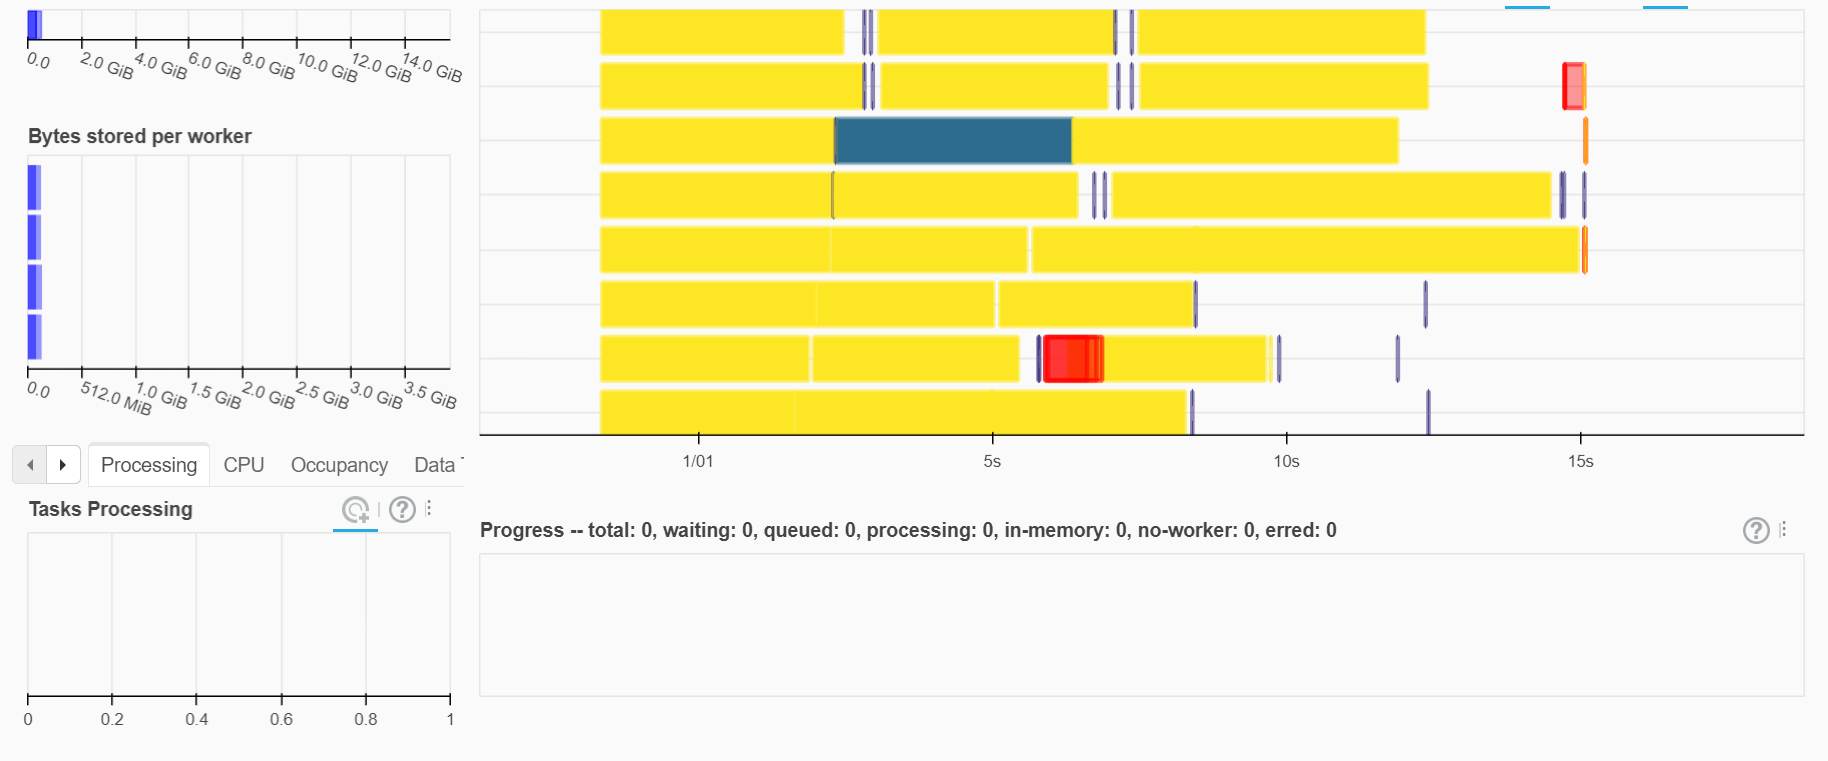
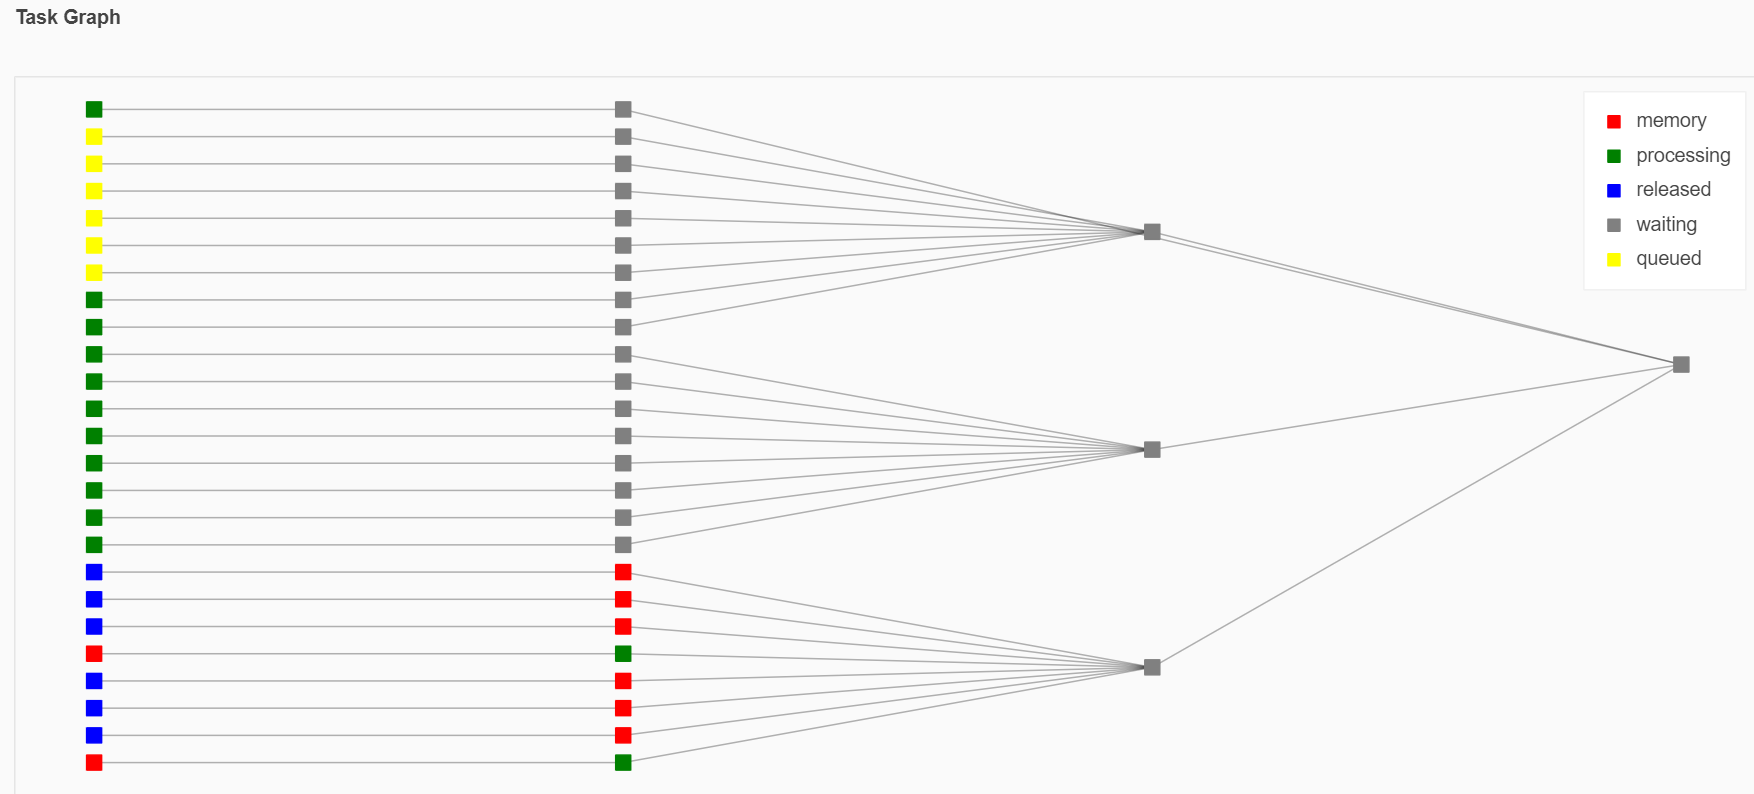

In [15]:
num_ = client.compute(people_bag.filter(lambda record: record['address']['city'] == 'Las Vegas').count())

In [16]:
num_

<Future: finished, type: int, key: finalize-d08636659a73c4f158469327b9f46272>

In [17]:
num_.result()

288

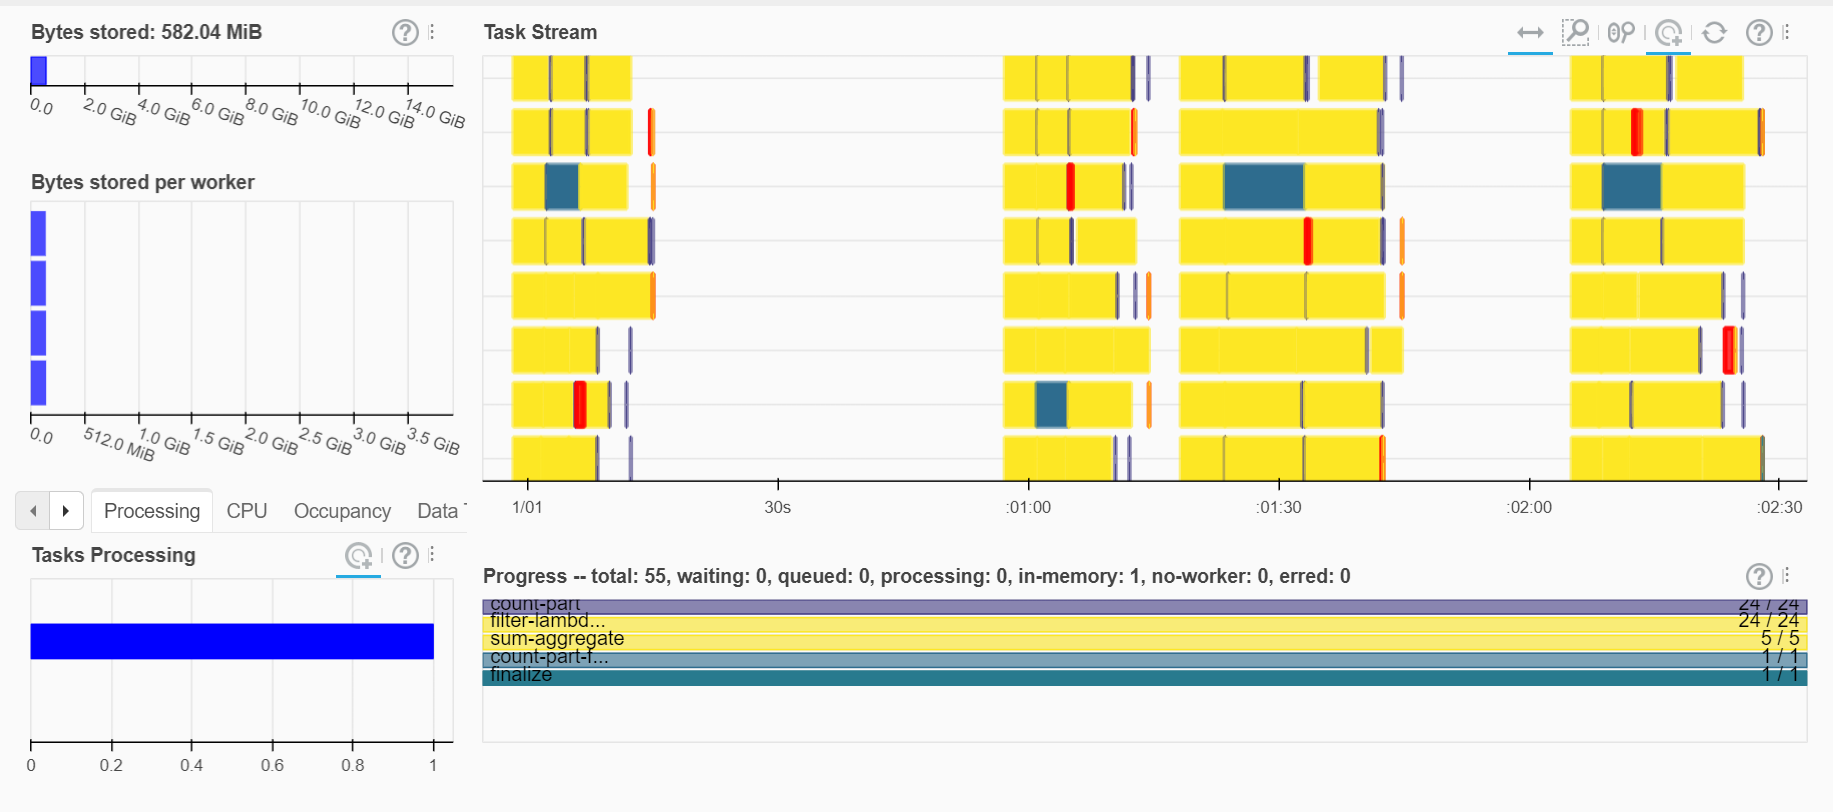
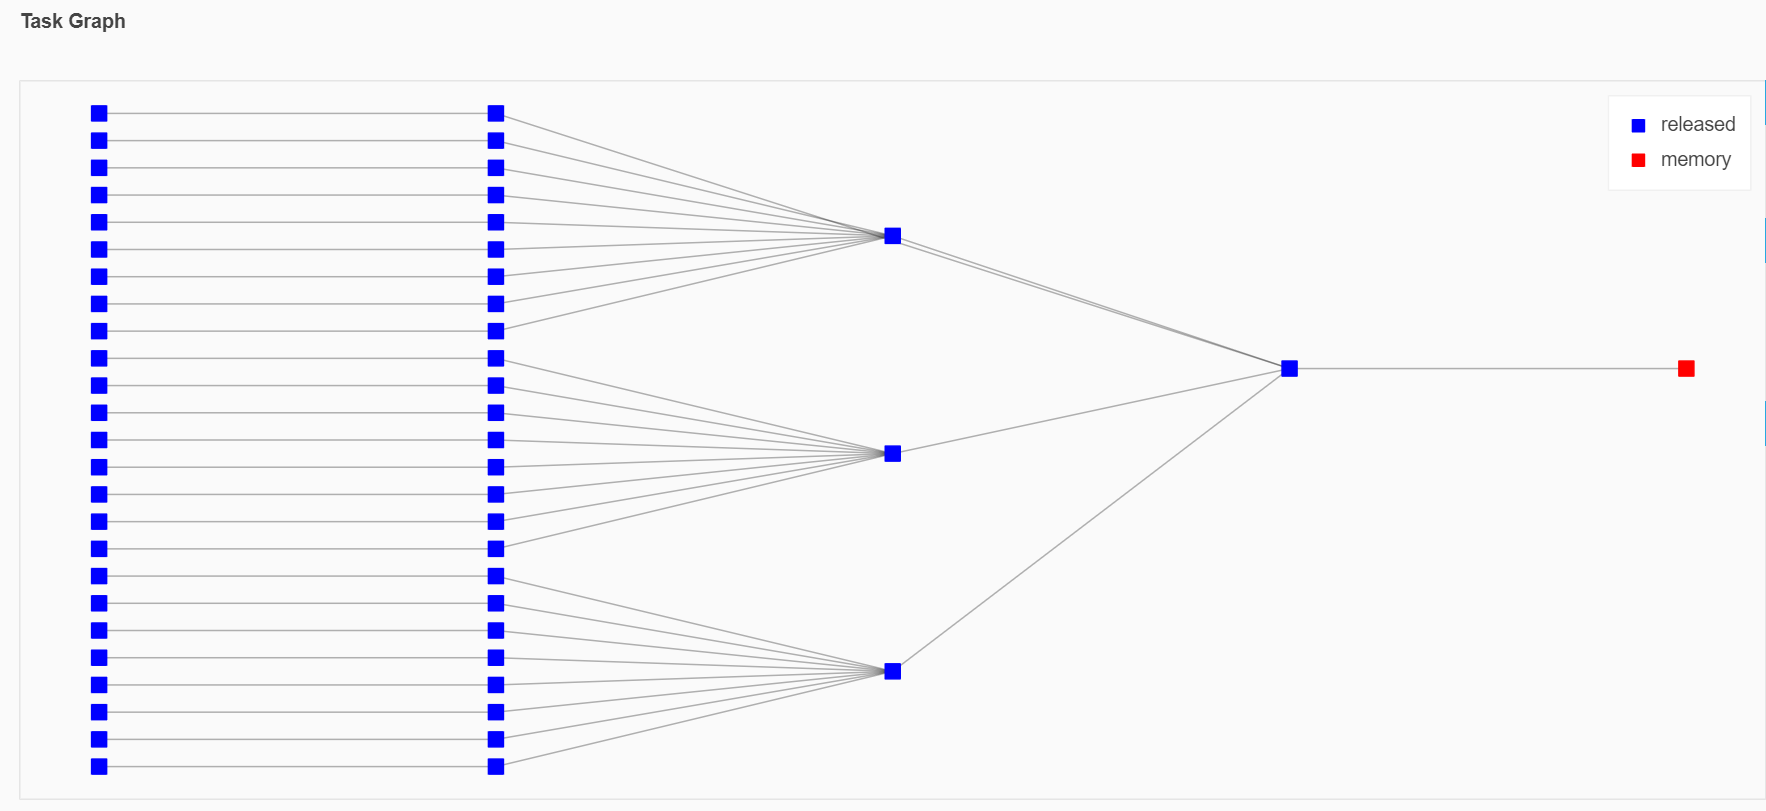

<p class="task" id="9"></p>

9\. Запустите `dask.distributed.Client`. Воспользовавшись `Bag`, полученном в задании 4, создайте `Bag` `young_people`, содержащий записи о людях, которым не более 50 лет. Вычислите и выведите на экран должность (`occupation`), которая встречается чаще всего, а также количество уникальных имен (имя хранится элементе с индексом 0 кортежа под ключом `name`). Выведите на экран эти значения и суммарное время вычисления двух этих значений.

In [26]:
%%time
young_people = people_bag.filter(lambda x: x['age'] <= 50)

occupation = young_people.pluck('occupation').frequencies(sort=True).topk(1, key=1)
names_count = young_people.pluck('name').pluck(0).distinct().count()

res = da.compute(occupation, names_count)
print(res[0][0][0], res[1], sep='\n')

Medical Officer
3323
CPU times: total: 328 ms
Wall time: 21.8 s


<p class="task" id="10"></p>

10\. Повторите решение задачи 9, предрассчитав значения `young_people` при помощи метода `persist`. Обратите внимание, что при запущенном `Client` метод `Bag.persist` стал неблокирующим. Отследите в дашборде (сделайте и вставьте скриншот) процедуру выполнения метода `persist`. После того, как он закончится, приступайте к дальнейшим вычислениям.

Сравните время выполнения двух решений.

In [27]:
young_people = people_bag.filter(lambda x: x['age'] <= 50).persist()

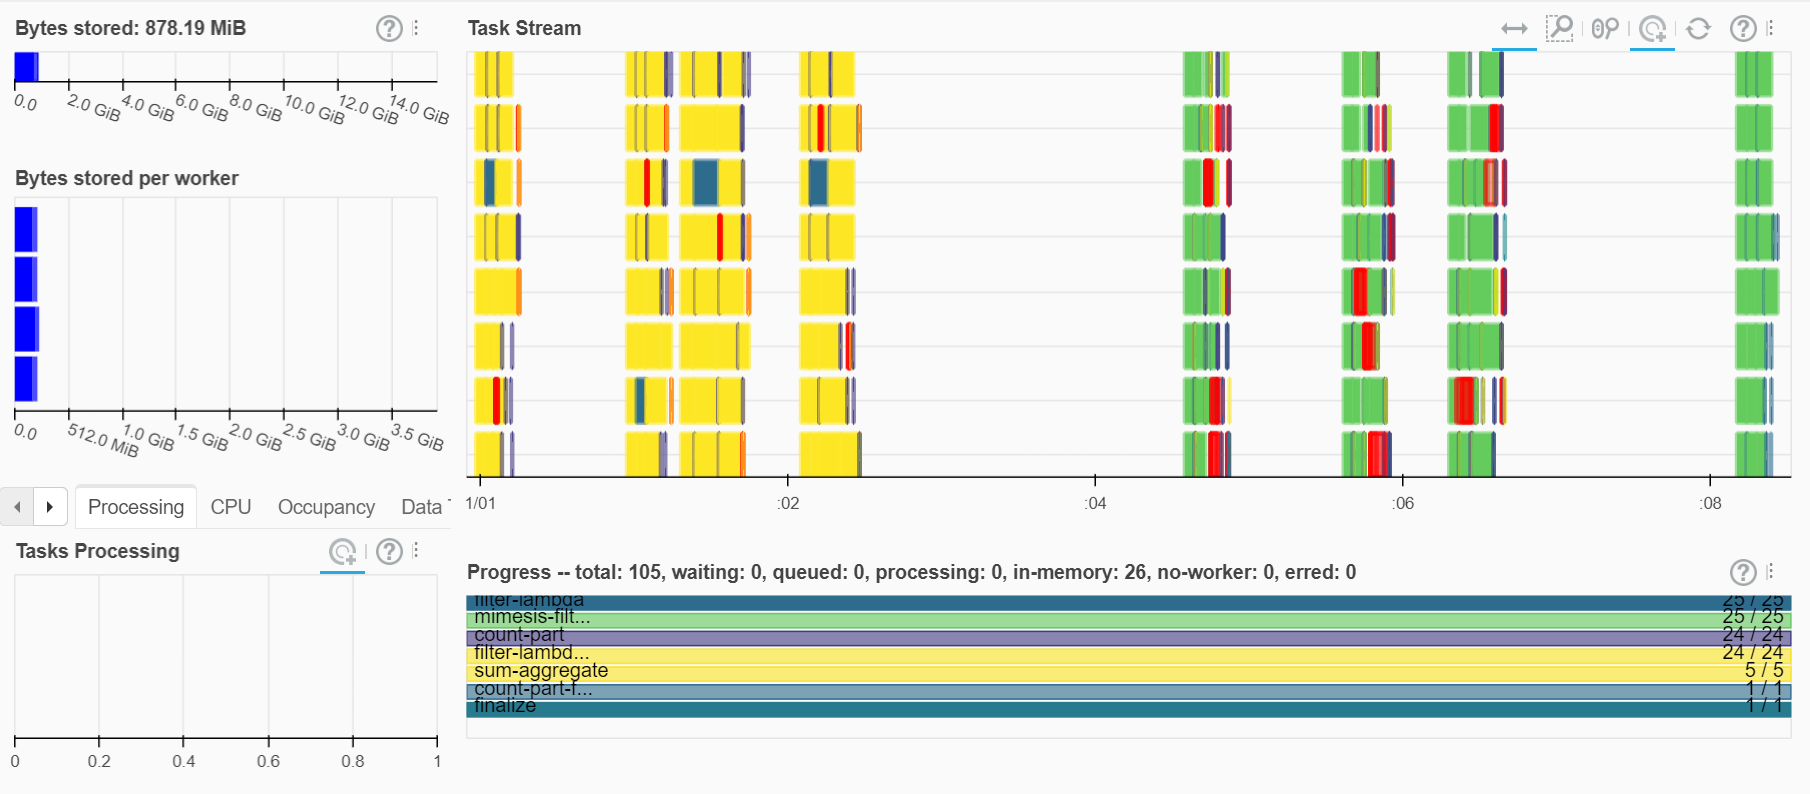

In [28]:
%%time
occupation = young_people.pluck('occupation').frequencies(sort=True).topk(1, key=1)
names_count = young_people.pluck('name').pluck(0).distinct().count()
res = da.compute(occupation, names_count)
print(res[0][0][0], res[1], sep='\n')

Medical Officer
3323
CPU times: total: 125 ms
Wall time: 3.04 s


Время выполнения уменьшилось в 7 раз